In [34]:
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import requests
import re
import nltk
import textcleaner
import pickle
import spacy
import jieba

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob
import textcleaner as tc
from nltk.stem import WordNetLemmatizer 
import re
import spacy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
! pip install --editable ..

Obtaining file:///Users/greenapple/project4
  Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0
  Running setup.py develop for src


# Load positions

In [8]:
# Load tokenized text for WA
pickling_out = open('/Users/greenapple/project4/data/processed/jobs_skills_token.pkl', 'rb')
jobs_skills = pickle.load(pickling_out)

In [126]:
# Data scientist/analyst jobs only
jobs_skills_d = jobs_skills.loc[jobs_skills.type=='positive']
jobs_skills_d.reset_index(inplace=True, drop=True)
jobs_skills_d.shape, jobs_skills.shape

((5058, 20), (8939, 20))

In [287]:
jobs_skills_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 20 columns):
company_name         5057 non-null object
description          5058 non-null object
job_title            5058 non-null object
link                 5058 non-null object
location             5058 non-null object
salary               5013 non-null object
type                 5058 non-null object
clean_text           5058 non-null object
noun                 5058 non-null object
noun_lemma           5058 non-null object
lemma                5058 non-null object
word                 5058 non-null object
sentences            5058 non-null object
start_stop           5058 non-null object
skills               5058 non-null object
clean_skills         5058 non-null object
word_skills          5058 non-null object
noun_skills          5058 non-null object
lemma_skills         5058 non-null object
noun_lemma_skills    5058 non-null object
dtypes: object(20)
memory usage: 790.4+ KB


In [127]:
# Not data scientist/analyst jobs only
jobs_skills_n = jobs_skills.loc[jobs_skills.type!='positive']
jobs_skills_n.reset_index(inplace=True, drop=True)
jobs_skills_n.shape, jobs_skills.shape

((3881, 20), (8939, 20))

In [13]:
jobs_skills_d.columns

Index(['company_name', 'description', 'job_title', 'link', 'location',
       'salary', 'type', 'clean_text', 'noun', 'noun_lemma', 'lemma', 'word',
       'sentences', 'start_stop', 'skills', 'clean_skills', 'word_skills',
       'noun_skills', 'lemma_skills', 'noun_lemma_skills'],
      dtype='object')

# Load resumes

In [238]:
# Load resumes
pickling_out = open('/Users/greenapple/project4/data/resumes/resumes_111219', 'rb')
resumes_list_1 = pickle.load(pickling_out)

In [239]:
# Add a job description as a positive control
pos1 = jobs_skills_d.skills[298] # Job298 returns high score for Resume1
resumes_list_1.append(pos1)

In [240]:
# Add a job description as a negative control
pos2 = jobs_skills_n.skills[3]
resumes_list_1.append(pos2)

In [241]:
# To dataframe
resumes = pd.DataFrame(resumes_list_1, columns = ['description'])
pd.set_option('max_colwidth', 200)  # display strings

In [242]:
resumes

,description
0,"ROB\nJOHNS,\nPH.D\n\nDATA SCIENTIST\n& Robjohns989@gmail.com\n& +1989.859.6960\n\n9 Seattle, WA\n\nin linkedin.com/in/RWJohns/\n© RWJohns\n\nAn experienced data-analyst\nwith a background in utili..."
1,JEREMY LEHNER\n\nSUMMARY\n\nDATA SCIENTIST | DATA ANALYST\n\nCONTACT\n\n \n\nData Scientist with a PhD in computational chemistry. Over 5 years experience in\nstochastic modeling of quantum system...
2,"DAVID ALEXANDER LOU\n\nDATA SCIENTIST | ECONOMIST\n\nSUMMARY\n\nData Scientist/Economist who is passionate about machine learning, data insight\n(story telling), and applied statistics/mathematics..."
3,"FATIMA LOUMAINI, CSM CCBA DATA SCIENTIST\n\n \n\nfatima.loumaini@gmail.com %& 4253669273 in linkedin.com/in/fatima-loumaini85 © floumaini\n\nSUMMARY\n\n8+ years of experience in various customer..."
4,Aisulu Omar\n\nLINKS\n\nPortfolio\nhttps://www.aisuluomar.com\n\nGithub\nhttps://github.com/AisOmar\n\nData Blog\nhttps://medium.com/@aisuluomar123\n\nLinkedIn\nlinkedin.com/in/aisulu-omar-6700551...
5,"EXPERIENCE\n\nEDUCATION\n\nSKILLS\n\nLaisha Conn\n\n4858 Schowalter Fords, Detroit, MI # Phot\n\n \n\nSENIOR CLINICAL TRIALS ASSISTANT\n\n‘Los Angeles, CA.\n09/2016 ~ present\n‘+ Perform assigned ..."
6,"Robert Smith Phono (22) 456789\n\nmall Infocuvikresume,com\nWebsite : wou, quikrestime, com\nLinkedin: linkedin.corn/quikresume\n‘Address; 1737 Marshullle Road, Alabarna\n\n \n\nClinical Research ..."
7,"REGINA MOSLEY, CCRC\n\n \n\nAtlanta Georgia « 404-727-1086 « in’\n\n \n\n3@emory.e\n\n \n\nlu\n\n \n\ninkedin.com/profile/view?id=592879548trk=hp identity-name\n\nLead Clinical Research Coordina..."
8,"EXPERIENCE\n\nEDUCATION\n\nSKILLS\n\nKattie Pouros\n\n1243 Christy Rue, Philadelphia, PA # Phone: +1 (555) 760 7462\n\nSENIOR CLINICAL TRIALS MANAGER\nBoston, MA\n12/2014 — present\n‘© Assists in ..."
9,"If you are highly analytical, enjoy working on teams, and have a strong intellectual curiosity to learn and apply new modeling methods to solve customer problems, the Data Science team at Porch j..."


In [243]:
# Process resumes
from src.features.pre_process_text import pre_process
from src.features.tokenize_text import tokenize_word, tokenize_noun, tokenize_lemma, tokenize_noun_lemma

resumes['clean_skills'] = resumes.description.apply(pre_process) # clean

# Tokenize:
resumes['noun_skills'] = resumes.clean_skills.apply(tokenize_noun)
resumes['word_skills'] = resumes.clean_skills.apply(tokenize_word)
resumes['noun_lemma_skills'] = resumes.clean_skills.apply(tokenize_noun_lemma)
resumes['lemma_skills'] = resumes.clean_skills.apply(tokenize_lemma)

# Recommender

In [376]:
# LDA
lda_vec_pos, lda_vec_res = docs_to_topics_lda(max_df=0.5,
                  min_df = 0.001,
                  stop_words = stop_words_1,
                  components=20, 
                  positions=jobs_skills.lemma_skills,
                  word_num=5,
                  resumes = resumes.lemma_skills)

# Cosine similarity
score = similarity(lda_vec_pos, lda_vec_res)

# Return 5 top positions
# top_pos = recommender(score.Resume1, 10)
# top_pos_n = recommender(score.Resume6, 10)
# top_pos, top_pos_n

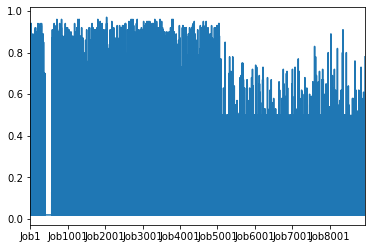

In [377]:
score.Resume1.plot()

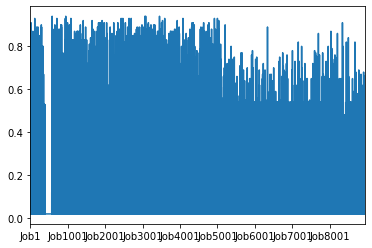

In [383]:
score.Resume2.plot()

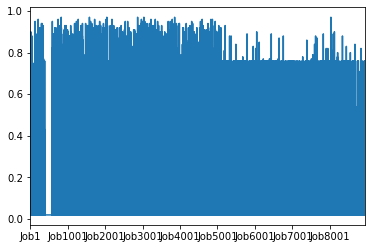

In [378]:
score.Resume3.plot()

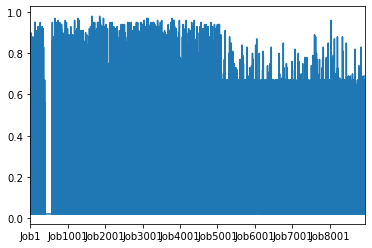

In [384]:
score.Resume4.plot()

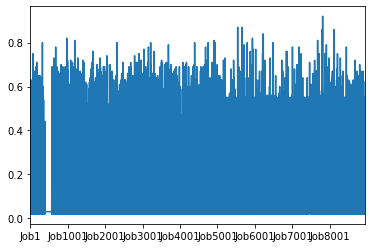

In [379]:
score.Resume6.plot()

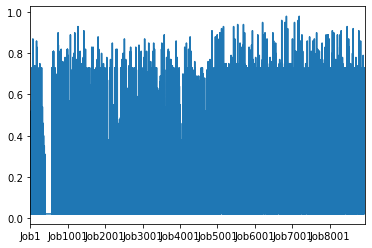

In [387]:
score.Resume7.plot()

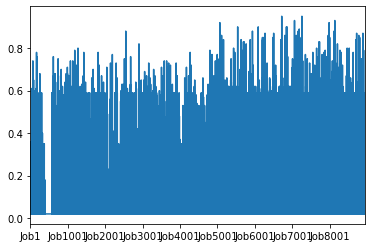

In [380]:
score.Resume8.plot()

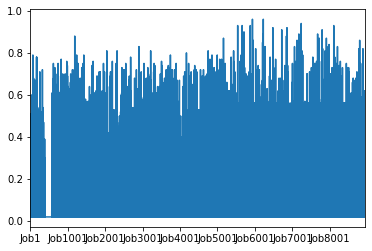

In [386]:
score.Resume9.plot()

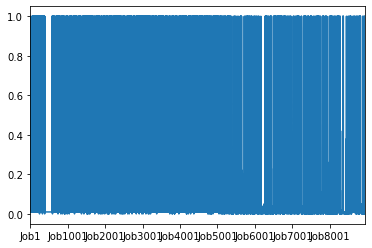

In [382]:
score.Resume10.plot()

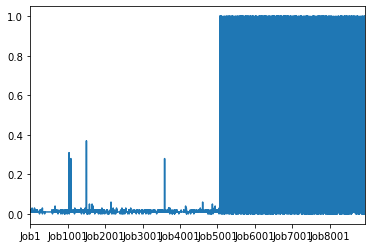

In [385]:
score.Resume11.plot()

In [359]:
resumes.description[9]
resumes.word_skills[10]
# resumes.columns

'    offices nationwide firm growing faster hiring talented senior civil project engineer    project manager responsibilities duties   designs develops plans drawings primarily commercial residential industrial land development projects include development preliminary layout final drawings roadways sanitary sewer lines utility design stormdrain storm water retention detention facilities waterlines mass grading drainage   organizes conducts engineering investigations planning work defined scope   researches feasibility alternative design approaches site conditions regulatory agency specifications   contributes development specifications permit applications writes miscellaneous reports   participates quality control checks maintaining quality standards work produced checking computations reviewing designs drawings performed   qualifications skills   b   s    m   s    civil engineering equivalent degree minimum   years experience civil engineering land    site development public works    

In [ ]:
# Remove duplicates and data rows that were inserted by indeed
# jobs_wa.drop_duplicates(inplace=True)
# a = jobs_wa.shape
jobs_skills.drop(jobs_skills.loc[jobs_skills.company_name == 'Seen by Indeed'].index, inplace=True)
# jobs_wa.reset_index(drop=True, inplace=True)
# b = jobs_wa.shape
# print(a, b)

In [338]:
jobs_skills.loc[jobs_skills.company_name == 'Seen by Indeed'].shape

(0, 20)

In [301]:
a

Job1531    0.01
Job672     0.01
Job1394    0.01
Job2378    0.01
Job4390    0.01
           ... 
Job3466    0.98
Job321     0.98
Job4698    0.98
Job752     0.99
Job1186    0.99
Name: Resume1, Length: 5058, dtype: float64

In [304]:
a=score.Resume1.sort_values(ascending=True)
jobs_skills_d.lemma_skills[2378]

'  candidate highly motivated detail orient strong customer service skill   will provide operational assistance organization maintenance datum ams software fulfill request datum internal external customer software include house application assist design delivery improvement house software application develop interpret technical documentation training end user procedure develop deliver training end user member use type software web application efficiently effectively support business objective collaborate internal stakeholder analyze map document business process enhance usability system assume number different role assign work large project team include limit business analyst project manager participant maintain organizational datum dictionary recommend annual update data management strategy communicate system change enhancement modification business requirement   verbally write documentation   project manager sponsor stakeholder issue solution understand develop maintain training mate

In [268]:
jobs_skills_d.lemma_skills[1906]

'  highly analytical enjoy work team strong intellectual curiosity learn apply new modeling method solve customer problem datum science team porch place right candidate strong datum science technical skill demonstrate ability lead team solve customer business problem    extensive experience datum mining statistical modeling machine learning technique interest lead technical team hand capacity   build expand broad array datum science model gbt propensity score nlp text classification regression bayesian inference etc   provide hand technical guidance datum scientist analyst encourage technical growth ensure proper application standard methodology   drive rd new model evaluate business opportunity   prioritize work team support broad business initiative   establish roadmap improve scalability datum pipeline model infrastructure   collaborate product team deliver solution enhance customer experience improve efficiency user acquisition   manage team datum scientist potentially machine lear

In [ ]:
## NMF
nmf_vec_pos, nmf_vec_res = docs_to_topics_nmf(max_df=0.99,
                  min_df = 0.001,
                  stop_words = stop_words_1,
                  components=20, 
                  positions=jobs_skills_d.lemma_skills,
                  word_num=5,
                  resumes = resumes.lemma_skills)

# Cosine similarity
score = similarity(nmf_vec_pos, nmf_vec_res)

# Return 5 top positions
top_pos = recommender(score.Resume1, 10)
top_pos_n = recommender(score.Resume6, 10)
top_pos, top_pos_n


In [226]:
# LSA
lsa_vec_pos, lsa_vec_res = docs_to_topics_lsa(max_df=0.99,
                  min_df = 0.001,
                  stop_words = stop_words_1,
                  components=20, 
                  positions=jobs_skills_d.lemma_skills,
                  word_num=5,
                  resumes = resumes.lemma_skills)

# Cosine similarity
score = similarity(lsa_vec_pos, lsa_vec_res)

# Return 5 top positions
top_pos = recommender(score.Resume1, 5)
top_pos_n = recommender(score.Resume6, 5)
top_pos, top_pos_n

(  Position ID  Similarity score
 0     Job1480              0.98
 1     Job3977              0.98
 2     Job3092              0.98
 3     Job2038              0.98
 4     Job2450              0.97,   Position ID  Similarity score
 0     Job1432              0.94
 1     Job1724              0.93
 2     Job2321              0.93
 3     Job3737              0.93
 4     Job4627              0.93)

In [178]:
score

,Resume1,Resume2,Resume3,Resume4,Resume5,Resume6,Resume7,Resume8
Job1,0.22,0.20,0.19,0.14,0.18,0.10,0.06,0.09
Job2,0.31,0.31,0.44,0.23,0.42,0.25,1.00,0.19
Job3,0.04,0.01,0.05,0.04,0.02,0.25,0.02,0.15
Job4,0.04,0.01,0.05,0.04,0.02,0.25,0.02,0.15
Job5,0.23,0.17,0.20,0.39,0.19,0.45,0.07,0.25
...,...,...,...,...,...,...,...,...
Job5054,0.04,0.01,0.05,0.04,0.02,0.25,0.02,0.15
Job5055,0.16,0.09,0.18,0.19,0.16,0.22,0.04,0.29
Job5056,0.10,0.08,0.09,0.16,0.21,0.10,0.03,0.05
Job5057,0.31,0.20,0.31,0.23,0.27,0.13,0.10,0.14


In [185]:
jobs_skills_d.skills[4627]

" If you are highly analytical, enjoy working on teams, and have a strong intellectual curiosity to learn and apply new modeling methods to solve customer problems, the Data Science team at Porch just might be the place for you The right candidate has strong data science technical skills and demonstrated an ability to lead a team to solve customer and business problems.  You should have extensive experience with data mining, statistical modeling, and machine learning techniques and an interest in leading a technical team in a hands-on capacity. What You Will Do Build or expand upon a broad array of data science models; GBT, propensity scoring, NLP text classification, regression, Bayesian inference, etc. Provide hands-on technical guidance to data scientists and analysts to encourage technical growth and ensure proper application of standard methodologies. Drive R&D on new models and evaluate business opportunities. Prioritize work across your team to support broader business initiativ

In [176]:
resumes.description[5]

'EXPERIENCE\n\nEDUCATION\n\nSKILLS\n\nLaisha Conn\n\n4858 Schowalter Fords, Detroit, MI # Phot\n\n \n\nSENIOR CLINICAL TRIALS ASSISTANT\n\n‘Los Angeles, CA.\n09/2016 ~ present\n‘+ Perform assigned administrative tasks to support team members with clinical trial execution\n‘© Assisting in the provision of professional and patient materials,\n‘© Assist in the preparation and follow-up of company-sponsored site quality audits and regulatory\nauthority inspections\n‘* With increasing independence, support data cleaning activities, performing data listings review, and query\ngeneration, etc\n‘© Work independently and within a team environment to meet study objectives and timelines\n+ Adhere to CFR, GCP/ICH, company policies, Clinical Operations and project specific quality documents\n(c.g. SOPs, work practices, training guides)\n‘* May perform site, SMO regulatory monitoring\n\nCLINICAL TRIALS ASSISTANT, DCRI\n\nNew York, NY\n06/2012 — 06/2016\n\n‘© Assist with development and implementatio

In [134]:
top_pos = recommender(score.Resume7, 5)
top_pos

,Position ID,Similarity score
0,Job933,0.93
1,Job5032,0.92
2,Job3583,0.92
3,Job4594,0.92
4,Job4912,0.92


In [102]:
# LSA
lsa_vec_pos, lsa_vec_res = docs_to_topics_lsa(max_df=0.5,
                  min_df = 0.005,
                  stop_words = stop_words_1,
                  components=15, 
                  positions=jobs_skills_d.noun_skills,
                  word_num=5,
                  resumes = resumes.noun_skills)

# Cosine similarity
score = similarity(lsa_vec_pos, lsa_vec_res)

# Return 5 top positions
top_pos = recommender(score.Resume6, 5)
top_pos

,Position ID,Similarity score
0,Job2529,1.0
1,Job4008,1.0
2,Job854,1.0
3,Job853,1.0
4,Job2164,1.0


In [105]:
score.Resume6.sort_values(ascending=False)[298]

1.0

In [113]:
score.loc[score.Resume6 == 1.0]['Resume6']

Job2       1.0
Job29      1.0
Job58      1.0
Job70      1.0
Job71      1.0
          ... 
Job5007    1.0
Job5008    1.0
Job5026    1.0
Job5027    1.0
Job5040    1.0
Name: Resume6, Length: 368, dtype: float64

## Models

# Functions

In [89]:
def recommender(score, num_pos):
    best = score.sort_values(ascending=False)[:num_pos]
    best = pd.Series.to_frame(best, name = 'Similarity score')
    best.reset_index(level=0, inplace=True)
    best.rename(columns={'index':'Position ID'}, inplace=True)
    
    return best

In [212]:
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.datasets import make_multilabel_classification


In [213]:
def docs_to_topics_lda(max_df=0.5,
                  min_df = 0.005,
                  stop_words = stop_words_1,
                  components=15, 
                  positions=jobs_skills_d.noun_skills,
                  word_num=5,
                  resumes = resumes):
    
    tf_idf = TfidfVectorizer(ngram_range=(1, 2),
                            max_df = max_df,
                            min_df = min_df,
                            stop_words = stop_words)   

    components = components  # number of LSA components
    lda = LatentDirichletAllocation(components, random_state = 5)

    # reduce dimensionality
    lda_vec_pos = lda.fit_transform(tf_idf.fit_transform(positions).toarray())  
    lda_vec_res = lda.transform(tf_idf.transform(resumes).toarray())  
    
    return lda_vec_pos, lda_vec_res


In [48]:
def docs_to_topics_lsa(max_df=0.5,
                  min_df = 0.005,
                  stop_words = stop_words_1,
                  components=15, 
                  positions=jobs_skills_d.noun_skills,
                  word_num=5,
                  resumes = resumes):
    
    tf_idf = TfidfVectorizer(ngram_range=(1, 2),
                            max_df = max_df,
                            min_df = min_df,
                            stop_words = stop_words)   

    components = components  # number of LSA components
    lsa = TruncatedSVD(components, random_state = 5)

    # reduce dimensionality
    lsa_vec_pos = lsa.fit_transform(tf_idf.fit_transform(positions).toarray())  
    lsa_vec_res = lsa.transform(tf_idf.transform(resumes).toarray())  
    
    return lsa_vec_pos, lsa_vec_res


In [203]:
def docs_to_topics_nmf(max_df=0.5,
                  min_df = 0.005,
                  stop_words = stop_words_1,
                  components=15, 
                  positions=jobs_skills_d.noun_skills,
                  word_num=5,
                  resumes = resumes):
    
    tf_idf = TfidfVectorizer(ngram_range=(1, 2),
                            max_df = max_df,
                            min_df = min_df,
                            stop_words = stop_words)   

    components = components  # number of LSA components
    nmf = NMF(components, random_state = 5)

    # reduce dimensionality
    nmf_vec_pos = nmf.fit_transform(tf_idf.fit_transform(positions).toarray())  
    nmf_vec_res = nmf.transform(tf_idf.transform(resumes).toarray())  
    
    return nmf_vec_pos, nmf_vec_res


In [ ]:
# Pre-process text
def pre_process(text):
    text_sub = re.sub('[/.\n:-]', ' ', text)  # Remove "/" and "."
    text_sub = re.sub('[,\(\)]', '', text_sub).lower()  # Remove "," and capital letters
    text_sub = re.sub('[^a-z\s]', '', text_sub) # Keep alphanumer characters only
#     re.sub('[%s]' % re.escape(string.punctuation), ' ', my_text)

    return text_sub

In [ ]:
# Tokenize text
def tokenize_lemma(text):
        
    # processer = spacy.load('en')
    tokenizer = spacy.load('en_core_web_sm')

    text_obj = tokenizer(text)
    text_str = ' '.join([token.lemma_ for token in text_obj if not token.is_stop])
    return text_str

In [ ]:
# Vectorize
def tf_idf(text1, text2):
    tfidf = TfidfVectorizer(ngram_range=(1, 2),               # vectorizer
                        stop_words='english', 
                        token_pattern="\\b[a-z][a-z]+\\b")
    X_tfidf = tfidf.fit_transform(text1).toarray()            # vectorize text1
    Z_tfidf = tfidf.transform(text2).toarray()                # vectorize text1
    
    
#     print('text1{}'.format(pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names()).head(5)))
#     print('text2{}'.format(pd.DataFrame(Z_tfidf, columns=tfidf.get_feature_names()).head(5)))
    
    return X_tfidf, Z_tfidf

In [ ]:
# Reduce dimensionality:
def lsa(X, Z):
    lsa = TruncatedSVD(4)
    X_lsa = lsa.fit_transform(X)
    Z_lsa = lsa.transform(Z)
  
    
    return X_lsa, Z_lsa

In [42]:
def similarity(X_red, Z_red):
    score = cosine_similarity(X_red, Z_red).round(2)
    
    column_labels = ['Resume'+str(i) for i in range(1, Z_red.shape[0]+1)]
    row_labels = ['Job'+str(i) for i in range(1, X_red.shape[0]+1)]
   
    similarity_df = pd.DataFrame(score, columns=column_labels, index=row_labels)
#     print(similarity_df)
        
    return similarity_df

### Toy example

In [ ]:
# Clean, lemma, tf-idf, lsa, cosine similarity

train_data['text'] = train_data.description.apply(pre_process) # clean
train_data['lemma'] = train_data.text.apply(tokenize_lemma) # tokenize and lemmatize

test_data_pos['text'] = test_data_pos.description.apply(pre_process)  # clean
test_data_pos['lemma'] = test_data_pos.text.apply(tokenize_lemma) # tokenize and lemmatize

resumes['text'] = resumes.description.apply(pre_process)  # clean
resumes['lemma'] = resumes.text.apply(tokenize_lemma) # tokenize and lemmatize

Tr_tfidf, R_tfidf = tf_idf(train_data.text, resumes.text) # vectorize
Tr_tfidf, Ts_tfidf = tf_idf(train_data.text, test_data_pos.text) # vectorize

Tr_lsa, R_lsa = lsa(Tr_tfidf, R_tfidf)  # reduce dimensionality
Tr_lsa, Ts_lsa = lsa(Tr_tfidf, Ts_tfidf)  # reduce dimensionality

score = similarity(Ts_lsa, R_lsa) # cosine similarity

In [ ]:
score

In [ ]:
train_data

# Stop words

In [21]:
stop_words_1 = [
    'yearexperience', 'year', 'years', 'porch', 'work', 'home', 'term', 'datum', 'hand', 'science', 'other', 
    're', 'sex', 'gender', 'data scientist', 'data scientists', 'scientists','scientist', 'com', 'age', 
    'analyst', 'analysts', 'race','hourexperience', 'job type', 'end', 'employee', 'employees','employers', 
    'employer', 'job', 'career', 'fish', 'violet','opportunities', 'business', 'disability', 'company', 
    'companies', 'stakeholders', 'talent', 'skill', 'skills', 'team', 'teams', 'experience', 'expert', 'hands', 
    'games', 'players', 'creativity','models', 'roles', 'application', 'specifications', 'change','issues', 
    'search', 'status', 'impact', 'changes', 'location', 'detail', 'insights', 'document', 'client', 'sets', 
    'set', 'detail', 'analytics', 'fusion','applications', 'candidates','standards', 'manager', 'assets', 
    'health', 'accommodation', 'services', 'service', 'transwest', 'program', 'commute', 'utilization',
    'technology', 'solutions', 'part', 'success', 'findings', 'notes', 'satisfaction', 'case', 'group', 'redviolet', 'trends', 'optimization',
    'others', 'account', 'strategy', 'bike parking', 'account', 'performance','preduction', 'relationship', 
    'waterfront views', 'manage', 'quality', 'type time', 'problems', 'projects', 'people', 'collaboration', 
    'strategies', 'programs', 'partner', 'core', 'operations', 'rsu', 'plans', 'methods', 'variety', 'revenue', 
    'data', 'technologies', 'visualizations', 'type', 'life', 'safety', 'analysis', 'time', 'design', 'research', 
    'relevance', 'passion', 'customer', 'learning', 'environment', 'tasks','family', 'benefits', 'development', 
    'complete', 'industry', 'user', 'organizations', 'customers', 'documentations', 'members', 'competencies',
    'homeowners', 'networking', 'apply', 'hire', 'homeowner', 'jobs', 'firm', 'position', 'entities',
    'tools', 'initiative', 'servicekey', 'intents', 'merit','bonuses', 'paid', 'asset', 'candidate', 
    'building', 'sector', 'employment', 'stakeholder', 'note', 'entity', 'finding', 'staff', 'drawing',
    'award', 'tool', 'latitude', 'view', 'button', 'matter', 'method', 'professionals', 'techniques',
    'states', 'house', 'holidayswe', 'handyman', 'requirementsperform', 'sr', 'sales', 'results',
    'length', 'ability', 'expertise', 'sr marketing', 'interviewdirectenergy', 'parks', 'child care',
    'religion', 'veteran', 'regard', 'days', 'directors', 'topics', 'salary', 'interview', 'care',
    'repairs', 'carpentry', 'role', 'tech', 'hundreds', 'requirements', 'platform', 'level', 'child',
    'orientation'
]

In [22]:
stop_words_2 = [
    'yearexperience', 'year', 'porch', 'work', 'home', 'term', 'datum', 'hand', 'science', 'other', 
    're', 'sex', 'gender', 'data scientist', 'scientist', 'com', 'age', 
    'analyst', 'race','hourexperience', 'job type', 'end', 'employee',
    'employer', 'job', 'career', 'fish', 'violet','opportunity', 'business', 'disability', 'company', 
    'stakeholders', 'talent', 'skill', 'team', 'experience', 'expert', 
    'player', 'creativity', 'role', 'application', 'specification', 'change','issue', 
    'search', 'status', 'impact', 'changes', 'location', 'detail', 'insight', 'document', 'client',
    'set', 'detail', 'analytics', 'fusion','applications', 'candidates','standards', 'manager', 'asset', 
    'health', 'accommodation', 'service', 'transwest', 'program', 'commute', 'utilization',
    'technology', 'solution', 'part', 'success', 'finding', 'satisfaction', 'case', 'group', 'redviolet', 'trends', 'optimization',
    'account', 'strategy', 'bike parking', 'account', 'performance','preduction', 'relationship', 
    'waterfront view', 'manage', 'quality', 'type time', 'people', 'collaboration', 
    'partner', 'core', 'variety', 'revenue', 
    'data', 'type', 'life', 'safety', 'analysis', 'time', 'design', 'research', 
    'relevance', 'passion', 'customer', 'learning', 'environment', 'task','family', 'benefit', 'development', 
    'complete', 'industry', 'day', 'sector'
]

In [23]:
stop_words_3 = []